In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from hmmlearn import hmm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nvatu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [105]:
rs = 12

In [37]:
df = pd.read_csv('all-data.csv', encoding="ISO-8859-1", header=None, names=['label', 'text'])
df

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [63]:
corpus = df['text'].values

In [65]:
corpus[1000]

"Incap Corporation Stock Exchange Release 4 May 2010 at 8.30 a.m. INCAP CORPORATION 'S DIRECTED SHARE ISSUE WAS SUBSCRIBED IN FULL The Board of Incap Corporation has approved the subscriptions of directed share issue ."

In [66]:
df['label'].value_counts()

neutral     2879
positive    1363
negative     604
Name: label, dtype: int64

In [68]:
def preprocess(text):
    text = word_tokenize(text.lower())
    return text

In [73]:
data = list(map(preprocess, corpus))

In [203]:
tfidf = TfidfVectorizer()
svd = TruncatedSVD(n_components=100)
transformed = tfidf.fit_transform(corpus)
X = svd.fit_transform(transformed)

In [204]:
X_cluster = X.reshape(-1, 1)

In [205]:
%%time

mo = KMeans(n_clusters=10)
mo.fit(X_cluster)

Wall time: 13.3 s


KMeans(n_clusters=10)

In [212]:
elbow = []
for i in [10, 15, 20, 25, 30, 35, 40, 45, 50]:
    cluster = KMeans(n_clusters=i)
    cluster.fit(X_cluster)
    elbow.append(cluster.inertia_)

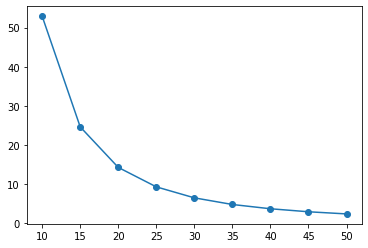

In [213]:
clusters = [10, 15, 20, 25, 30, 35, 40, 45, 50]
plt.scatter(clusters, elbow)
plt.plot(clusters, elbow)
plt.show()

In [175]:
y = df['label']

encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [176]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=rs)

In [177]:
model = LogisticRegression()
model.fit(Xtrain, ytrain)

LogisticRegression()

In [178]:
model.score(Xtrain, ytrain)

0.847265221878225

In [179]:
model.score(Xtest, ytest)

0.743298969072165

In [180]:
X[df['label'] == 'positive']

array([[ 2.24244427e-01, -1.90894643e-01, -6.05295913e-02, ...,
         5.92387356e-05,  3.80389361e-03,  1.00838328e-02],
       [ 3.07802017e-01, -8.12483298e-02,  1.04901157e-01, ...,
        -5.25692164e-03, -3.00546090e-03,  5.90546055e-03],
       [ 5.94872599e-02, -5.33840931e-02, -3.79265505e-03, ...,
        -8.61405017e-03,  7.62744305e-03,  2.41145224e-03],
       ...,
       [ 4.94790364e-02,  1.44100926e-03,  2.04518289e-02, ...,
        -2.96015874e-03,  2.53904173e-03,  1.94126670e-02],
       [ 7.26379594e-02, -3.02390307e-02, -2.14007857e-02, ...,
        -1.12496816e-02, -2.21718200e-03, -1.63391259e-02],
       [ 2.13879670e-01, -5.90631401e-02,  4.56720508e-02, ...,
         2.89206004e-03, -1.53273058e-02,  2.78665509e-03]])

In [181]:
hmm_models = dict()
for c in np.unique(ytrain):
    hmm_models[c] = hmm.MultinomialHMM(n_components=10)
    hmm_models[c].fit(Xtrain[ytrain == c])

In [182]:
def predict(data):
    global hmm_models
    values = [model.score(data) for model in hmm_models.values()]
    return label[np.argmax(values)]

In [183]:
encoder.inverse_transform([0, 1, 2])

array(['negative', 'neutral', 'positive'], dtype=object)

In [184]:
def score(X, y):
    acc = 0
    for datum, c in zip(X, y):
        pred = predict([datum])
        acc += c == pred
    return acc / X.shape[0]

In [185]:
score(Xtest, ytest)

0.49072164948453606

In [186]:
score(Xtrain, ytrain)

0.5296697626418989